### get dataset
Download  Twitter Sentiment Analysis Dataset and extract.

The Twitter Sentiment Analysis Dataset contains 1,578,627 classified tweets, each row is marked as 1 for positive sentiment and 0 for negative sentiment. 

In [1]:
!wget http://thinknook.com/wp-content/uploads/2012/09/Sentiment-Analysis-Dataset.zip
!unzip Sentiment-Analysis-Dataset.zip


Redirecting output to ‘wget-log’.
Archive:  Sentiment-Analysis-Dataset.zip
  inflating: Sentiment Analysis Dataset.csv  


## set dataset to dataframe and drop unused columns
Set dataset to pandas dataframe.

Since  only "Sentiment" and "SentimentText" columns are used for sentiment analysis, drop other columns.

In [6]:
import pandas as pd
csv = "Sentiment Analysis Dataset.csv"
df = pd.read_csv(csv, error_bad_lines=False)


# drop columns other than Sentiment and SentimentText
df = df[['Sentiment','SentimentText']]

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


## preprocess text
make function to remove hashtags, mentions, links and special character.


In [0]:
import re

def cleanText(text):
  clean_words = []
  
  for word in text.split():
    word = word.lower()
    if 'http' not in word and not word.startswith('@')\
       and not word.startswith('#') and word != 'RT' and not word.startswith('&'):
      word = re.sub(r'[\-.,]', '', word)  
      clean_words.append(word)
 
  return " ".join(clean_words)
      

make function to  remove stopwords from text.



In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def removeStopwords(text):
  clean_words = []
  
  for word in text.split():
    if word not in stopwords.words("english"):
      clean_words.append(word)
 
  return " ".join(clean_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


run cleanText() function

In [0]:
df_size = df.shape
cleaned_text = []

cleaned_text = df.apply(lambda row: cleanText(row['SentimentText']), axis=1)

df['SentimentText'] = cleaned_text

## Zipf's law
check Zipf's law before running removeStopwords() function since it will remove a lot words from dataset.
 
make words dataframe from dataset.

In [0]:
columns = ["word", "count", "freq"]
words = pd.DataFrame(columns=columns)

for index, row in df.iterrows():
  for i in row['SentimentText'].split():
    if i in words['word'].tolist():
      words.loc[words['word'] == i, "count"] += 1
    else:
      words = words.append({'word':i, 'count': 1}, ignore_index=True)


calcurate word's frequency

In [11]:
total_count = words['count'].sum()
words['freq'] = words['count'] / total_count
words = words.sort_values(by="count", ascending=False)
words.reset_index(drop=True)

,word,count,freq
0,i,70,0.0633484
1,to,33,0.0298643
2,a,26,0.0235294
3,my,22,0.0199095
4,the,21,0.0190045
5,in,16,0.0144796
6,is,15,0.0135747
7,of,13,0.0117647
8,it,11,0.00995475
9,now,10,0.00904977


plot Zipf's law graph with occurrence of each words

Text(0.5,1,"Zipf's law(occurrence of each words)")

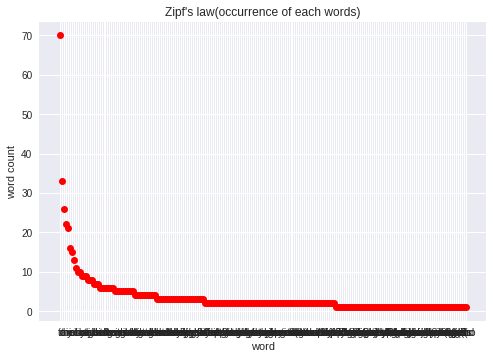

In [12]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array(words.loc[:20, 'word'].values)
y = words.loc[:20, 'count'].values

# plot occurrence of each words
plt.xticks(range(len(y)), x)
plt.plot(y, "ro")
plt.xlabel("word")
plt.ylabel("word count")
plt.title("Zipf's law(occurrence of each words)")


 after checked Zipf's law run removeStopwords function 

In [0]:
cleaned_text = df.apply(lambda row: removeStopwords(row['SentimentText']), axis=1)


df['SentimentText'] = cleaned_text

##split cleaned dataset to train and test dataset

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


# build my own classifier
use Naive Bayes classifier  since it is very efficient and easy to understand.

use Laplace smoothing for a case when a word only appears in positive or negative text.

In [0]:
import numpy as np

class myClassifier():
  def __init__(self):
    columns = ["word", "pos", "neg"]
    self._words = pd.DataFrame(columns=columns)

  def train(self, df):
    df_size = df.shape
    total = df_size[0]
    total_pos = df.Sentiment.sum()
    total_neg = total - total_pos 
    
    # set words in text to dataframe
    for index, row in df.iterrows():
      for i in row['SentimentText'].split():
        if i in self._words['word'].tolist():
          self._words.loc[self._words['word'] == i, "pos"] += row['Sentiment']
          self._words.loc[self._words['word'] == i, "neg"] += 1 if not row['Sentiment'] else 0
        else:
          self._words = self._words.append({'word':i, 'pos': row['Sentiment'], 'neg': 1 if not row['Sentiment'] else 0 }, ignore_index=True)
          

  def accuracy(self, df):
    df_size = df.shape
    total = df_size[0]
    total_pos = df.Sentiment.sum()
    total_neg = total - total_pos 
    alpha = 1
    shape_words = self._words.shape
    total_words = shape_words[0]
    testResult = []
    
    for index, row in df.iterrows():
      likelifoood_pos = []
      likelifoood_neg = []
      for i in row['SentimentText'].split():
        if i in self._words['word'].tolist():
          likelifoood_pos.append((self._words.loc[self._words['word'] == i]['pos'].values[0] + alpha)/(total_pos + total_words))
          likelifoood_neg.append((self._words.loc[self._words['word'] == i]['neg'].values[0] + alpha)/(total_neg + total_words))

      
      testResult.append(1 if np.prod(likelifoood_pos) > np.prod(likelifoood_neg) else 0)
    
    df['testResult'] = testResult
    successful = df.loc[df['Sentiment'] == df['testResult']].shape
    
    #print accuracy of prediction
    print("accuracy of prediction: {:04.2f}".format(successful[0]/total))
    
  def top_ten_words(self, negpos):
    print("top 10 {} words".format("Positive" if negpos == 1 else "Negative"))
    
    col = ["pos", "neg"] if negpos == 1 else ["neg", "pos"]
    top_ten = self._words.loc[self._words[col[0]] > self._words[col[1]]].sort_values(by = [col[0],col[1]], ascending=[False, True])[:10]
    top_ten = top_ten.reset_index(drop=True)
    for i in range(10):
      print("{}. {}\t\tcount:{}".format(i+1, top_ten.loc[i, 'word'], top_ten.loc[i, col[0]]))


## train classifier with train dataset

In [0]:
nvClasifier = myClassifier()
nvClasifier.train(train)


## check accuracy of classifier with test dataset

In [17]:
nvClasifier.accuracy(test)

accuracy of prediction: 0.40


## show top 10 positive words

In [18]:
nvClasifier.top_ten_words(1)

top 10 Positive words
1. go		count:4
2. get		count:3
3. see		count:3
4. got		count:3
5. already		count:2
6. boom		count:2
7. seen		count:2
8. tonight		count:2
9. one		count:2
10. gonna		count:2


## show top 10 negative words

In [19]:
nvClasifier.top_ten_words(0)

top 10 Negative words
1. i'm		count:6
2. think		count:5
3. like		count:4
4. much		count:4
5. new		count:4
6. work		count:4
7. really		count:4
8. im		count:4
9. want		count:4
10. love		count:3
